In [2]:
import numpy as np  #Importing NumPy for numerical operations
import pandas as pd  #Importing pandas for data manipulation and analysis
import re  #Importing regular expressions for text preprocessing
import matplotlib.pyplot as plt  #Importing Matplotlib for data visualization

#Importing the Tokenizer to convert text into sequences of integers
from tensorflow.keras.preprocessing.text import Tokenizer

#Importing pad_sequences to ensure sequences have the same length
from tensorflow.keras.preprocessing.sequence import pad_sequences

#Importing LabelEncoder to convert categorical labels into numerical values
from sklearn.preprocessing import LabelEncoder

#Importing train_test_split to split the dataset into training and test sets
from sklearn.model_selection import train_test_split

#Importing Sequential to build a linear stack of layers for the model
from tensorflow.keras.models import Sequential

#Importing various layers for building the neural network
from tensorflow.keras.layers import Embedding, Dense, LSTM, Dropout, Bidirectional, BatchNormalization

#Importing the Adam optimizer for compiling the model
from tensorflow.keras.optimizers import Adam

#Importing RandomOverSampler to handle class imbalances by oversampling minority classes
from imblearn.over_sampling import RandomOverSampler

#Importing Counter to count the occurrences of each class
from collections import Counter

2025-03-06 18:01:37.388381: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:01:37.393016: I external/local_xla/xla/tsl/cuda/cudart_stub.cc:32] Could not find cuda drivers on your machine, GPU will not be used.
2025-03-06 18:01:37.409372: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1741284097.436880   47646 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1741284097.445534   47646 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-03-06 18:01:37.472425: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU ins

In [3]:
# Reading a CSV file into a DataFrame (you'll need to specify the file path)
data = pd.read_csv('emotion_dataset.csv')  # Replace 'file_path.csv' with your actual file path

In [4]:
data.head()  # Displaying the first few rows of the dataset

,text,label
0,i didnt feel humiliated,sadness
1,i can go from feeling so hopeless to so damned...,sadness
2,im grabbing a minute to post i feel greedy wrong,anger
3,i am ever feeling nostalgic about the fireplac...,love
4,i am feeling grouchy,anger


In [5]:
# Function to preprocess text data
def preprocess_text(text):
    text = text.lower()  # Convert text to lowercase
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = re.sub(r'@\w+', '', text)  # Remove mentions
    text = re.sub(r'#\w+', '', text)  # Remove hashtags
    text = re.sub(r'[^a-z\s]', '', text)  # Remove special characters and numbers
    text = re.sub(r'\s+', ' ', text).strip()  # Remove extra whitespaces
    return text

# Apply text preprocessing to the 'text' column
data['text'] = data['text'].astype(str).apply(preprocess_text)

In [6]:
# Initialize and apply label encoding to the 'label' column
label_encoder = LabelEncoder()
data['label'] = label_encoder.fit_transform(data['label'])

In [7]:
data.head()  # Displaying the first few rows of the dataset

,text,label
0,i didnt feel humiliated,3
1,i can go from feeling so hopeless to so damned...,3
2,im grabbing a minute to post i feel greedy wrong,0
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,0


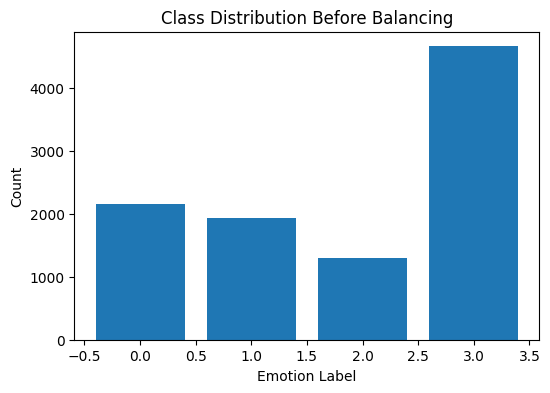

In [8]:
# Visualize class distribution before balancing
plt.figure(figsize=(6, 4))  # Set figure size
plt.bar(Counter(data['label']).keys(), Counter(data['label']).values())  # Plot a bar chart of label counts
plt.title("Class Distribution Before Balancing")  # Set plot title
plt.xlabel("Emotion Label")  # Set x-axis label
plt.ylabel("Count")  # Set y-axis label
plt.show()  # Show the plot

In [9]:
# Initialize a Tokenizer object to convert text into sequences of integers
tokenizer = Tokenizer()
# Fit the tokenizer on the text data to build the vocabulary
tokenizer.fit_on_texts(data["text"])
# Calculate the vocabulary size by getting the length of the word index and adding 1 for the padding token
vocab_size = len(tokenizer.word_index) + 1
# Define the maximum length of sequences for padding
max_length = 100

# Convert the text data into sequences of integers based on the tokenizer's vocabulary
X = tokenizer.texts_to_sequences(data["text"])
# Pad the sequences to ensure they are all of the same length (max_length)
X = pad_sequences(X, maxlen=max_length, padding='post')
# Extract the labels from the data
y = data["label"].values

In [10]:
# Randomly oversample the data to balance the class distribution
ros = RandomOverSampler(random_state=42)
X_resampled, y_resampled = ros.fit_resample(X, y)

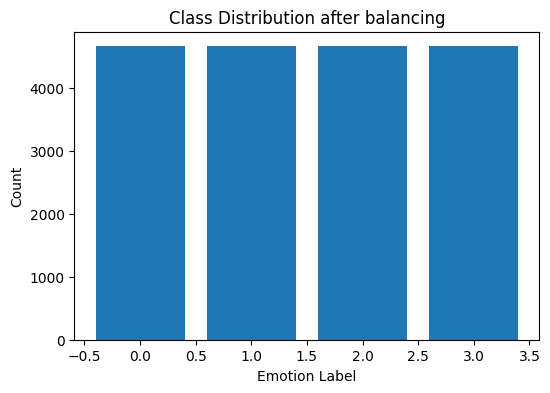

In [11]:
# Plot the class distribution after balancing
plt.figure(figsize=(6, 4))
# Create a bar chart showing the count of each class label
plt.bar(Counter(y_resampled).keys(), Counter(y_resampled).values())
plt.title("Class Distribution after balancing")
plt.xlabel("Emotion Label")
plt.ylabel("Count")
plt.show()

In [12]:
# Split the resampled data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42)

In [13]:
# Define the LSTM model architecture
model = Sequential([
    # Embedding layer to convert integer sequences into dense vectors of fixed size
    Embedding(input_dim=vocab_size, output_dim=200, input_length=max_length),
    # First Bidirectional LSTM layer with 128 units, returning sequences for the next LSTM layer
    Bidirectional(LSTM(128, return_sequences=True)),
    # Batch normalization to stabilize and speed up training
    BatchNormalization(),
    # Dropout layer to prevent overfitting by randomly setting 30% of the input units to 0
    Dropout(0.3),
    # Second Bidirectional LSTM layer with 64 units
    Bidirectional(LSTM(64)),
    # Batch normalization
    BatchNormalization(),
    # Dropout layer
    Dropout(0.3),
    # Dense layer with 32 units and ReLU activation function
    Dense(32, activation='relu'),
    # Batch normalization
    BatchNormalization(),
    # Output dense layer with softmax activation for multi-class classification
    Dense(len(np.unique(y_resampled)), activation='softmax')
])

/workspaces/ml-emotion-detection/venv/lib/python3.12/site-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(
2025-03-06 18:02:18.333652: E external/local_xla/xla/stream_executor/cuda/cuda_driver.cc:152] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [14]:
# Compile the model with the Adam optimizer, sparse categorical crossentropy loss, and accuracy metric
model.compile(optimizer=Adam(learning_rate=0.001), loss='sparse_categorical_crossentropy', metrics=['accuracy'])

# Train the model on the training data
history = model.fit(
    X_train, y_train,  # Training data and labels
    epochs=10,  # Number of epochs to train the model
    batch_size=32,  # Number of samples per gradient update
    validation_split=0.1,  # Fraction of the training data to be used as validation data
    verbose=1  # Verbosity mode (1 = progress bar)
)

Epoch 1/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 151s 336ms/step - accuracy: 0.2953 - loss: 1.6014 - val_accuracy: 0.5897 - val_loss: 1.4036
Epoch 2/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 78s 185ms/step - accuracy: 0.9143 - loss: 0.2800 - val_accuracy: 0.7303 - val_loss: 0.6867
Epoch 3/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 178ms/step - accuracy: 0.9775 - loss: 0.0803 - val_accuracy: 0.9692 - val_loss: 0.1034
Epoch 4/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 178ms/step - accuracy: 0.9874 - loss: 0.0442 - val_accuracy: 0.9639 - val_loss: 0.1185
Epoch 5/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 177ms/step - accuracy: 0.9907 - loss: 0.0321 - val_accuracy: 0.9672 - val_loss: 0.1172
Epoch 6/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 180ms/step - accuracy: 0.9942 - loss: 0.0229 - val_accuracy: 0.9618 - val_loss: 0.1364
Epoch 7/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 179ms/step - accuracy: 0.9909 - loss: 0.0279 - val_accuracy: 0.9699 - val_loss: 0.1354
Epoch 8/10
420/420 ━━━━━━━━━━━━━━━━━━━━ 75s 178ms/step - accuracy: 0.9910 - loss: 

In [15]:
# Evaluate the model on the test dataset
test_loss, test_accuracy = model.evaluate(X_test, y_test, verbose=0)
# Print the test accuracy with 4 decimal places
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.9577


In [19]:
# Import the joblib library for saving Python objects
import joblib

# Save the trained model to a file named "emotion_model.h5"
model.save("emotion_model.h5")

# Save the tokenizer object to a file named "tokenizer.jb"
joblib.dump(tokenizer, "tokenizer.jb")

# Save the label encoder object to a file named "label_encoder.jb"
joblib.dump(label_encoder, "label_encoder.jb")

['label_encoder.jb']